In [1]:
%load_ext tensorboard

In [2]:
import datetime
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from midi_utils import *

In [3]:
x = np.load('samples.npy')

In [4]:
x.shape

(217, 128, 512)

In [5]:
x = x[:,:,::16]

In [6]:
x.shape

(217, 128, 32)

In [7]:
x[x < 120] = 0
x[x > 0] = 1

In [8]:
X_train = x[:-28]
X_valid = x[-28:]

In [9]:
np.random.seed(42)

_, num_notes, num_ticks = X_train.shape

def create_model():

    def rounded_accuracy(y_true, y_pred):
        return tf.keras.metrics.binary_accuracy(
            tf.round(y_true),
            tf.round(y_pred),
        )

    stacked_encoder = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=[num_notes, num_ticks]),
        tf.keras.layers.Dense(1024, activation="selu"),
        tf.keras.layers.Dense(512, activation="selu"),
    ])
    stacked_decoder = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1024, activation="selu", input_shape=[512]),
        tf.keras.layers.Dense(num_notes * num_ticks, activation="sigmoid"),
        tf.keras.layers.Reshape([num_notes, num_ticks])
    ])
    stacked_ae = tf.keras.models.Sequential([stacked_encoder, stacked_decoder])

    stacked_ae.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.SGD(learning_rate=1.5),
        metrics=[rounded_accuracy],
    )

    return stacked_encoder, stacked_decoder, stacked_ae

In [10]:
log_dir = os.path.join(
    "logs",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
]

stacked_encoder, stacked_decoder, model = create_model()
history = model.fit(
    X_train,
    X_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_valid, X_valid),
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/100
1/1 - 7s - loss: 0.6947 - rounded_accuracy: 0.8524 - val_loss: 0.6936 - val_rounded_accuracy: 0.6276
Epoch 2/100
1/1 - 1s - loss: 0.6942 - rounded_accuracy: 0.6101 - val_loss: 0.6930 - val_rounded_accuracy: 0.6121
Epoch 3/100
1/1 - 0s - loss: 0.6934 - rounded_accuracy: 0.5979 - val_loss: 0.6924 - val_rounded_accuracy: 0.6104
Epoch 4/100
1/1 - 0s - loss: 0.6927 - rounded_accuracy: 0.5973 - val_loss: 0.6918 - val_rounded_accuracy: 0.6117
Epoch 5/100
1/1 - 0s - loss: 0.6919 - rounded_accuracy: 0.5992 - val_loss: 0.6911 - val_rounded_accuracy: 0.6147
Epoch 6/100
1/1 - 0s - loss: 0.6910 - rounded_accuracy: 0.6028 - val_loss: 0.6903 - val_rounded_accuracy: 0.6183
Epoch 7/100
1/1 - 0s - loss: 0.6901 - rounded_accuracy: 0.6069 - val_loss: 0.6894 - val_rounded_accuracy: 0.6219
Epoch 8/100
1/1 - 0s - loss: 0.6891 - rounded_accuracy: 0.6110 - val_loss: 0.6885 - val_rounded_accuracy: 0.6279
Epoch 9/100
1/1 - 0s - loss: 0.6880 - rounded_accuracy: 0.6171 - val_loss: 0.6873 - val_rounded_

In [11]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 25516), started 0:35:51 ago. (Use '!kill 25516' to kill it.)

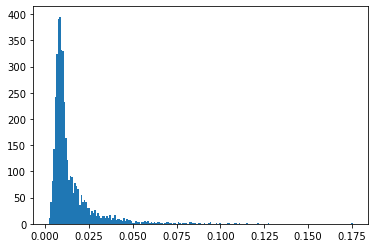

In [12]:
plt.hist(model(X_train[0:1, :, :]).numpy().ravel(), bins=200);

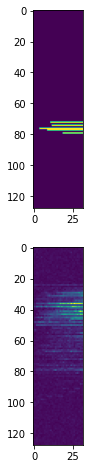

In [13]:
k = 50

plt.figure(figsize=(16, 8))
plt.subplot(2,1,1)
plt.imshow(X_train[k,:,:])
plt.subplot(2,1,2)
plt.imshow(model(X_train[k:(k + 1), :, :]).numpy().squeeze())
plt.show()